# 导入函数库

In [147]:
import numpy as np
import torch
import queue
import gym

In [148]:
torch.set_default_dtype(torch.float64)

# MDP记忆

In [149]:
class memory:
  def __init__(self, env):
    self.env = env
    self.state_dimension = self.env.observation_space.shape[0]
    try:self.action_dimension = self.env.action_space.shape[0]
    except:self.action_cnt=self.env.action_space.n; self.action_dimension = 1
    self.width = self.state_dimension + self.action_dimension + 1
    self.data = queue.LifoQueue()

  def put(self, state, action, reward):
    self.data.put(np.hstack((state, action, reward)))

  def get(self):
    data_row =  self.data.get() 
    state = data_row[:self.state_dimension]
    action = data_row[self.state_dimension:self.state_dimension+self.action_dimension]
    reward = data_row[-1]
    return state, action, reward

  def empty(self):
    return self.data.empty()

In [150]:
# env = gym.make('CartPole-v0')
# test_memory = memory(env)
# state = env.reset()
# while True:
#   action = env.action_space.sample()
#   next_state ,reward, done, info = env.step(action)
#   test_memory.put(state, action, reward)
#   print('input:',state,action,reward)
#   state = next_state
#   if done:
#     break
# while not test_memory.empty():
#   state, action, reward = test_memory.get()
#   print('output:',state,action,reward)


# 神经网络

torch交叉熵链接：https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html#crossentropyloss

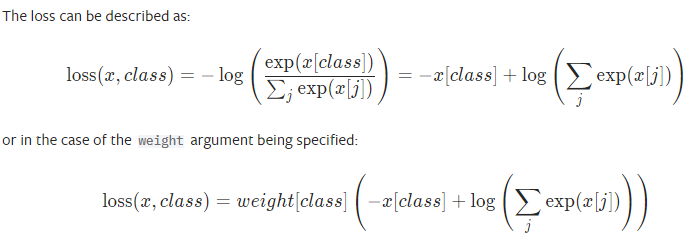

In [151]:
class network:
  def __init__(self, env, hidden_dimension=20, learning_rate=1e-2):
    self.env = env
    self.hidden_dimension = hidden_dimension
    self.learning_rate = learning_rate

    self.input_dimension = self.env.observation_space.shape[0]
    self.output_dimension = self.env.action_space.n

    self.model = self.__create_network()
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
    self.entropy = torch.nn.CrossEntropyLoss(reduction='none')

  def optimize(self, state, action, value):
    state = torch.tensor(state)
    action = torch.tensor(action).squeeze()
    value = torch.tensor(value).squeeze()

    action_probably_value = self.model(state)
    cross_entropy = self.entropy(action_probably_value, action.squeeze())
    loss = torch.mean(cross_entropy * value)

    # action_probably_value = self.model(state)
    # action_probably_value = torch.nn.functional.softmax(action_probably_value, dim=-1)
    # loss = torch.log(action_probably_value)
    # loss = value * loss[np.arange(len(action)), action]
    # loss = -loss.mean()

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    return loss.item()
  
  def __call__(self, state):
    action_value = self.model(state)
    return action_value

  def __create_network(self):
    return torch.nn.Sequential(torch.nn.Linear(self.input_dimension,self.hidden_dimension),
                            torch.nn.ReLU(),
                            torch.nn.Linear(self.hidden_dimension,self.output_dimension)
                            )

In [152]:
# env = gym.make('CartPole-v0')
# test_network = network(env)
# state = env.reset()
# action = env.action_space.sample()
# next_state ,reward, done, info = env.step(action)
# test_network.optimize(state, action, reward)

# 策略智能体

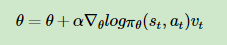

In [153]:
class agent_policy:
  def __init__(self, env, gamma=0.99):
    self.env = env
    self.gamma = gamma

    self.action_dimension = self.env.action_space.n
    self.state_dimension = self.env.observation_space.shape[0]

    self.network_policy = network(self.env)
    self.memory_epoch = memory(self.env)

  def output_action(self, state):
    state = torch.tensor(state)
    action_probablity = self.network_policy(state)
    action_probablity = torch.nn.functional.softmax(action_probablity, dim=-1)
    return np.random.choice(range(self.action_dimension), 
                            p=action_probablity.tolist())

  def learn(self):
    mdp_length = self.memory_epoch.data.qsize()
    mdp_value = np.zeros((mdp_length, 1))
    mdp_state = np.zeros((mdp_length, self.state_dimension))
    mdp_action = np.zeros((mdp_length, 1), dtype=np.long)
    mdp_value_last = 0
    for i in range(mdp_length)[::-1]:
      state, action, reward = self.memory_epoch.get()
      mdp_value_last = reward + self.gamma * mdp_value_last
      mdp_value[i] = mdp_value_last
      mdp_state[i] = state
      mdp_action[i] = np.array([int(action)])

    mdp_value = mdp_value - np.mean(mdp_value)
    self.network_policy.optimize(mdp_state, mdp_action, mdp_value)


# 策略执行类

In [164]:
class execute_policy:
  def __init__(self, env_name, epoch=1000):
    self.env_name = env_name
    self.epoch = epoch

    self.env = gym.make(self.env_name)
    self.agent = agent_policy(self.env)

    self.print_epoch = 100

  def start_execute(self):
    for i in range(self.epoch):
      state = self.env.reset()
      total_reward = 0
      while True:
        action = self.agent.output_action(state)
        next_state, reward, done, info = self.env.step(action)
        total_reward += reward
        self.agent.memory_epoch.put(state, action, reward)
        state = next_state
        if done :
          break
      if (i+1) % self.print_epoch == 0:
        print(str(i),'total rewad : %s'%total_reward, end="\r\n")
      self.agent.learn()


In [165]:
test_policy = execute_policy('CartPole-v0')
test_policy.start_execute()

99 total rewad : 200.0
199 total rewad : 200.0
299 total rewad : 200.0
399 total rewad : 200.0
499 total rewad : 200.0
599 total rewad : 200.0
699 total rewad : 200.0
799 total rewad : 200.0
899 total rewad : 200.0
999 total rewad : 200.0


In [ ]:
%debug

# 测试工具

## 交叉熵计算方式

In [ ]:
array = [[4.0, 2.0, 1.0], [0.0, 5.0, 1.0]]

In [ ]:
array[1]

[0.0, 5.0, 1.0]

In [ ]:
array = labels

In [ ]:
ans1 = []
total = 0
for each in array[0]:
  total += np.exp(each)
for each in array[0]:
  ans1.append(np.exp(each)/total )
ans1

[0.8437947344813395, 0.11419519938459449, 0.04201006613406605]

In [ ]:
ans2 = []
total = 0
for each in array[1]:
  total += np.exp(each)
for each in array[1]:
  ans2.append(np.exp(each)/total )
ans2

[0.0065732631853090825, 0.9755587549443864, 0.0178679818703045]

In [ ]:
ans = [ans1, ans2]
ans

[[0.8437947344813395, 0.11419519938459449, 0.04201006613406605],
 [0.0065732631853090825, 0.9755587549443864, 0.0178679818703045]]

In [ ]:
labels = [[1.0, 0.0, 0.0], [0.0, 0.8, 0.2]]

In [ ]:
pans1 = []
total = 0
for each in labels[0]:
  total += np.exp(each)
for each in labels[0]:
  pans1.append(np.exp(each)/total )
pans2 = []
total = 0
for each in labels[1]:
  total += np.exp(each)
for each in labels[1]:
  pans2.append(np.exp(each)/total )
pans = [pans1, pans2]
pans

[[0.5761168847658291, 0.21194155761708547, 0.21194155761708547],
 [0.2248735469714781, 0.500465282520298, 0.27466117050822386]]

In [ ]:
-np.log(ans[0][0])

0.16984601955628567

In [ ]:
-np.log(ans[1][1]) * 0.8  -np.log(ans[1][2]) *  0.2 

In [ ]:
for i in range(2):
  ans = 0
  for j in range(3):
    ans += np.log(1/ans1[i][j]) * ans2[i][j]
  print(ans)

1.2295538076417132
2.247757307029109


In [ ]:
ans1 = []
total = 0
for each in [1.2295538076417132, 2.247757307029109]:
  total += np.exp(each)
for each in [1.2295538076417132, 2.247757307029109]:
  ans1.append(np.exp(each)/total )
ans1

[0.26537748476108364, 0.7346225152389163]

## torch的交叉熵

In [ ]:
import torch

In [128]:
entropy = torch.nn.CrossEntropyLoss(weight=torch.tensor([0.0,2.0,0.0]))
entropy(torch.tensor([[0.0, 5.0, 1.0]]), torch.tensor([1]))

tensor(0.0247)

In [ ]:
m = torch.nn.Softmax(dim=0)
input = torch.randn(2, 3)
output = m(input)

In [ ]:
input

tensor([[-0.6630,  0.4187,  0.3441],
        [-0.0870,  0.1581,  0.1338]])

In [ ]:
output

tensor([[0.3598, 0.5648, 0.5524],
        [0.6402, 0.4352, 0.4476]])